In [256]:
from sogym.env import sogym
import warnings
import dreamerv3
from dreamerv3 import embodied
from dreamerv3 import agent as agt
from embodied.envs import from_gym


In [257]:
from sogym.env import sogym
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update({
    'run.logdir': 'logdir/run1',
    'run.train_ratio': 64,
    'run.log_every': 30,  # Seconds
    'batch_size': 16,
    'encoder.mlp_keys': ['conditions','volume','design_variables','n_steps_left'],
    'decoder.mlp_keys':  ['conditions','volume','design_variables','n_steps_left'],
    'encoder.cnn_keys': '$^',
    'decoder.cnn_keys': '$^',
    'jax.platform': 'cpu',
    'envs.amount':16,
})

logdir = embodied.Path(config.run.logdir)
step = embodied.Counter()
logger = embodied.Logger(step, [
    embodied.logger.TerminalOutput(),
    embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
    embodied.logger.TensorBoardOutput(logdir),
    # embodied.logger.WandBOutput(logdir.name, config),
    # embodied.logger.MLFlowOutput(logdir.name),
])

import crafter
from embodied.envs import from_gym
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)

agent = agt.Agent(env.obs_space, env.act_space, step, config)
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/run1/checkpoint.pkl', keys=['agent'])
obs=env._env.reset()
obs=env._obs(obs, 0.0, is_first=True)
obs = {k: embodied.convert(v) for k, v in obs.items()}

act, state = agent.policy(obs, mode='eval')

Encoder CNN shapes: {}
Encoder MLP shapes: {'conditions': (9,), 'design_variables': (48,), 'n_steps_left': (1,), 'volume': (1,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'conditions': (9,), 'design_variables': (48,), 'n_steps_left': (1,), 'volume': (1,)}
JAX devices (1): [CpuDevice(id=0)]
Policy device: TFRT_CPU_0
Train devices: TFRT_CPU_0
Tracing train function.
Optimizer model_opt has 16,541,499 variables.
Optimizer actor_opt has 1,056,780 variables.
Optimizer critic_opt has 1,181,439 variables.
Loading checkpoint: logdir/run1/checkpoint.pkl
Loading checkpoint with step 11105024
Loaded checkpoint from 355 seconds ago.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/jax/core.py:1440   │
│ in _len                                                                                          │
│                                                                                                  │
│   1437                                                                                           │
│   1438   def _len(self, ignored_tracer):                                                         │
│   1439 │   try:                                                                                  │
│ ❱ 1440 │     return self.shape[0]                                                                │
│   1441 │   except IndexError as err:                                                             │
│   1442 │     raise TypeError("len() of unsized object") from err  # same as numpy error          │
│   1443                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: tuple index out of range

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   43 obs=env._obs(obs, 0.0, is_first=True)                                                       │
│   44 obs = {k: embodied.convert(v) for k, v in obs.items()}                                      │
│   45                                                                                             │
│ ❱ 46 act, state = agent.policy(obs, mode='eval')                                                 │
│   47                                                                                             │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/jaxagent │
│ .py:109 in policy                                                                                │
│                                                                                                  │
│   106 │   rng = self._next_rngs()                                                                │
│   107 │   varibs = self.varibs if self.single_device else self.policy_varibs                     │
│   108 │   if state is None:                                                                      │
│ ❱ 109 │     state, _ = self._init_policy(varibs, rng, obs['is_first'])                           │
│   110 │   else:                                                                                  │
│   111 │     state = tree_map(                                                                    │
│   112 │   │     jnp.asarray, state, is_leaf=lambda x: isinstance(x, list))                       │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/ninjax.p │
│ y:197 in wrapper                                                                                 │
│                                                                                                  │
│   194 │   statics = tuple(sorted([(k, v) for k, v in kw.items() if k in static]))                │
│   195 │   kw = {k: v for k, v in kw.items() if k not in static}                                  │
│   196 │   if not hasattr(wrapper, 'keys'):                                                       │
│ ❱ 197 │     created = init(statics, rng, *args, **kw

In [6]:
driver = embodied.Driver(env)
driver.on_episode(lambda ep, worker: per_episode(ep))
driver.on_step(lambda tran, _: step.increment())
policy = lambda *args: agent.policy(*args, mode='eval')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 driver = embodied.Driver(env)                                                                │
│   2 driver.on_episode(lambda ep, worker: per_episode(ep))                                        │
│   3 driver.on_step(lambda tran, _: step.increment())                                             │
│   4 policy = lambda *args: agent.policy(*args, mode='eval')                                      │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/embodied │
│ /core/driver.py:18 in __init__                                                                   │
│                                                                                                  │
│   15   }                                                                                         │
│   16                                                                                             │
│   17   def __init__(self, env, **kwargs):                                                        │
│ ❱ 18 │   assert len(env) > 0                                                                     │
│   19 │   self._env = env                                                                         │
│   20 │   self._kwargs = kwargs                                                                   │
│   21 │   self._on_steps = []                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [80]:
driver.reset()
driver._state

In [7]:
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)
env._obs

<bound method FromGym._obs of FromGym(len=0, obs_space={'conditions': Space(dtype=float32, shape=(9,), low=-1.0, high=1.0), 'design_variables': Space(dtype=float32, shape=(48,), low=-3.1415927410125732, high=3.1415927410125732), 'n_steps_left': Space(dtype=float32, shape=(1,), low=0.0, high=1.0), 'volume': Space(dtype=float32, shape=(1,), low=0.0, high=1.0), 'reward': Space(dtype=float32, shape=(), low=-inf, high=inf), 'is_first': Space(dtype=bool, shape=(), low=False, high=True), 'is_last': Space(dtype=bool, shape=(), low=False, high=True), 'is_terminal': Space(dtype=bool, shape=(), low=False, high=True)}, act_space={'action': Space(dtype=float32, shape=(6,), low=-1.0, high=1.0), 'reset': Space(dtype=bool, shape=(), low=False, high=True)})>

In [11]:
env._env.reset()


{'conditions': array([ 0.5882353 ,  0.990099  ,  0.        ,  0.        ,  0.98039216,
         0.        ,  0.3       ,  0.57357645, -0.81915206], dtype=float32),
 'design_variables': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'volume': array([0.], dtype=float32),
 'n_steps_left': array([1.], dtype=float32)}

In [12]:
env._env.Phi


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
obs=env._env.reset()

In [66]:
env._obs(obs, 0.0, is_first=True)

{'conditions': array([ 0.64705884,  0.        ,  0.        ,  0.990099  ,  0.98039216,
         0.990099  ,  0.3       ,  0.57357645, -0.81915206], dtype=float32),
 'design_variables': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'volume': array([0.], dtype=float32),
 'n_steps_left': array([1.], dtype=float32),
 'reward': 0.0,
 'is_first': True,
 'is_last': False,
 'is_terminal': False}

In [258]:
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)
env = dreamerv3.wrap_env(env, config)
env = embodied.BatchEnv([env], parallel=False)
driver = embodied.Driver(env)
driver.on_step(lambda tran, _: step.increment())

In [259]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/run1/checkpoint.pkl', keys=['agent'])

print('Start evaluation loop.')
policy = lambda *args: agent.policy(*args, mode='eval')
driver(policy, steps=1)

Loading checkpoint: logdir/run1/checkpoint.pkl
Loading checkpoint with step 11105024
Loaded checkpoint from 371 seconds ago.
Start evaluation loop.
Tracing policy function.
Tracing policy function.


In [328]:
driver.reset()

(5151, 8)


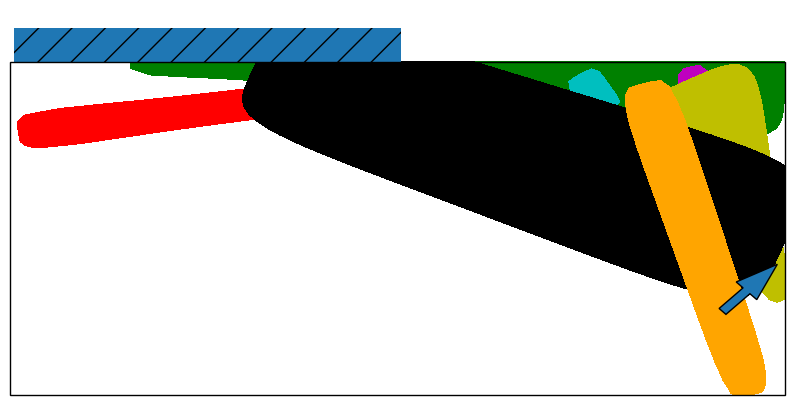

In [337]:
driver(policy, steps=1)
print(driver._env._envs[0]._env.Phi.shape)
driver._env._envs[0]._env.plot(train_viz=False)

In [338]:
print(driver._env._envs[0]._env.compliance)


20.0748340053959


In [252]:
import importlib
import pathlib
import sys
import warnings
from functools import partial as bind
from embodied import wrappers

env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)
def make_envs(config, **overrides):
  suite, task = config.task.split('_', 1)
  ctors = []
  for index in range(config.envs.amount):
    ctor = lambda: wrap_env(env, config)
    if config.envs.parallel != 'none':
      ctor = bind(embodied.Parallel, ctor, config.envs.parallel)
    if config.envs.restart:
      ctor = bind(wrappers.RestartOnException, ctor)
    ctors.append(ctor)
  envs = [ctor() for ctor in ctors]
  return embodied.BatchEnv(envs, parallel=(config.envs.parallel != 'none'))

In [253]:
def make_replay(
    config, directory=None, is_eval=False, rate_limit=False, **kwargs):
  assert config.replay == 'uniform' or not rate_limit
  length = config.batch_length
  size = config.replay_size // 10 if is_eval else config.replay_size
  if config.replay == 'uniform' or is_eval:
    kw = {'online': config.replay_online}
    if rate_limit and config.run.train_ratio > 0:
      kw['samples_per_insert'] = config.run.train_ratio / config.batch_length
      kw['tolerance'] = 10 * config.batch_size
      kw['min_size'] = config.batch_size
    replay = embodied.replay.Uniform(length, size, directory, **kw)
  elif config.replay == 'reverb':
    replay = embodied.replay.Reverb(length, size, directory)
  elif config.replay == 'chunks':
    replay = embodied.replay.NaiveChunks(length, size, directory)
  else:
    raise NotImplementedError(config.replay)
  return replay




def wrap_env(env, config):
  args = config.wrapper
  for name, space in env.act_space.items():
    if name == 'reset':
      continue
    elif space.discrete:
      env = wrappers.OneHotAction(env, name)
    elif args.discretize:
      env = wrappers.DiscretizeAction(env, name, args.discretize)
    else:
      env = wrappers.NormalizeAction(env, name)
  env = wrappers.ExpandScalars(env)
  if args.length:
    env = wrappers.TimeLimit(env, args.length, args.reset)
  if args.checks:
    env = wrappers.CheckSpaces(env)
  for name, space in env.act_space.items():
    if not space.discrete:
      env = wrappers.ClipAction(env, name)
  return env

In [254]:
config = config.update({
    'run.logdir': 'logdir/run1',
    'run.train_ratio': 64,
    'run.log_every': 30,  # Seconds
    'batch_size': 16,
    'encoder.mlp_keys': ['conditions','volume','design_variables','n_steps_left'],
    'decoder.mlp_keys':  ['conditions','volume','design_variables','n_steps_left'],
    'encoder.cnn_keys': '$^',
    'decoder.cnn_keys': '$^',
    'jax.platform': 'cpu',
    'envs.amount':16,
})

In [255]:
args = config.run.update(batch_steps=config.batch_size * config.batch_length)

replay = make_replay(config, logdir / 'replay')
env = make_envs(config)
agent = agt.Agent(env.obs_space, env.act_space, step, config)
embodied.run.train(agent, env, replay, logger, args)

Encoder CNN shapes: {}
Encoder MLP shapes: {'conditions': (9,), 'design_variables': (48,), 'n_steps_left': (1,), 'volume': (1,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'conditions': (9,), 'design_variables': (48,), 'n_steps_left': (1,), 'volume': (1,)}
JAX devices (1): [CpuDevice(id=0)]
Policy device: TFRT_CPU_0
Train devices: TFRT_CPU_0
Tracing train function.
Optimizer model_opt has 16,541,499 variables.
Optimizer actor_opt has 1,056,780 variables.
Optimizer critic_opt has 1,181,439 variables.
Logdir logdir/run1
Observation space:
  conditions       Space(dtype=float32, shape=(9,), low=-1.0, high=1.0)
  design_variables Space(dtype=float32, shape=(48,), low=-3.1415927410125732, high=3.1415927410125732)
  n_steps_left     Space(dtype=float32, shape=(1,), low=0.0, high=1.0)
  volume           Space(dtype=float32, shape=(1,), low=0.0, high=1.0)
  reward           Space(dtype=float32, shape=(), low=-inf, high=inf)
  is_first         Space(dtype=bool, shape=(), low=False, high=True)


────────────────────────────────────────────────── Step 8758340 ───────────────────────────────────────────────────

episode/length 8 / episode/score 0 / episode/sum_abs_reward 0 / episode/reward_rate 0


Existing checkpoint not found.
Saving checkpoint: logdir/run1/checkpoint.pkl
Start training loop.
Saved chunk: 20230219T234815F077514-7eUv5uKLOSCS9oJPmQlVYa-0000000000000000000000-133.npzSaved chunk: 20230219T234815F077627-56tXJCUxXYbcU0UCgbvc4y-0000000000000000000000-133.npz

Saved chunk: 20230219T234815F077413-6L10fLJ5GkZS5lGCHuNP9S-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F077302-7b7Lo1dVURdwm3vdnVKDF9-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F077826-6eQt7rjtDj6bVaOC3TUz2v-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F077727-0OQMrkTBdwXH6mTPJmVFkP-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F077206-3tS4aeTkvzM3QKoFLWdq5I-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F077933-1TwjuVvmRzpFkBm3XvTtov-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F077022-3vbhCKGSG2SwE3fTvlPjAg-0000000000000000000000-133.npz
Saved chunk: 20230219T234815F078542-72A2SubhQqUqpwDksTdYXb-0000000000000000000000-133.npz
S

────────────────────────────────────────────────── Step 8758453 ───────────────────────────────────────────────────

train/action_mag 4.66 / train/action_max 4.25 / train/action_mean 0.09 / train/action_min -4.66 / train/action_std 
1.05 / train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / 
train/actor_opt_grad_norm 3.7e-4 / train/actor_opt_grad_steps 1 / train/actor_opt_loss -6.02 / train/adv_mag 2.1e-6
/ train/adv_max 1.9e-6 / train/adv_mean -2.3e-8 / train/adv_min -2.1e-6 / train/adv_std 3.7e-7 / 
train/conditions_loss_mean 8.26 / train/conditions_loss_std 3.42 / train/cont_avg 0.89 / train/cont_loss_mean 0.89 
/ train/cont_loss_std 0.4 / train/cont_neg_acc 0.75 / train/cont_neg_loss 0.55 / train/cont_pos_acc 0.31 / 
train/cont_pos_loss 0.93 / train/cont_pred 0.42 / train/cont_rate 0.89 / train/design_variables_loss_mean 43.03 / 
train/design_variables_loss_std 8.35 / train/dyn_loss_mean 7.13 / train/dyn_loss_std 0.35 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 4.06 / train/extr_critic_critic_opt_grad_steps 1 / 
train/extr_critic_critic_opt_loss 2.9e4 / train/extr_critic_mag 0 / train/extr_critic_max 0 / 
train/extr_critic_mean 0 / train/extr_critic_min 0 / train/extr_critic_std 0 / train/extr_return_normed_mag 2.1e-6 
/ train/extr_return_normed_max 1.9e-6 / train/extr_return_normed_mean -1.6e-8 / train/extr_return_normed_min 
-2.1e-6 / train/extr_return_normed_std 3.7e-7 / train/extr_return_rate 0 / train/extr_return_raw_mag 2.1e-6 / 
train/extr_return_raw_max 1.9e-6 / train/extr_return_raw_mean -2.3e-8 / train/extr_return_raw_min -2.1e-6 / 
train/extr_return_raw_std 3.7e-7 / train/extr_reward_mag 7.2e-7 / train/extr_reward_max 7.2e-7 / 
train/extr_reward_mean -6.3e-9 / train/extr_reward_min -7.2e-7 / train/extr_reward_std 2.1e-7 / 
train/model_loss_mean 62.89 / train/model_loss_std 8.86 / train/model_opt_grad_norm 291.66 / 
train/model_opt_grad_steps 1 / train/model_opt_loss 6.3e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.48 / train/n_steps_left_loss_std 0.66 / 
train/policy_entropy_mag 8.26 / train/policy_entropy_max 8.26 / train/policy_entropy_mean 7.68 / 
train/policy_entropy_min 6.5 / train/policy_entropy_std 0.22 / train/policy_logprob_mag 19.81 / 
train/policy_logprob_max -4.26 / train/policy_logprob_mean -7.71 / train/policy_logprob_min -19.81 / 
train/policy_logprob_std 1.77 / train/policy_randomness_mag 0.98 / train/policy_randomness_max 0.98 / 
train/policy_randomness_mean 0.94 / train/policy_randomness_min 0.85 / train/policy_randomness_std 0.02 / 
train/post_ent_mag 108.01 / train/post_ent_max 108.01 / train/post_ent_mean 107.28 / train/post_ent_min 106.69 / 
train/post_ent_std 0.21 / train/prior_ent_mag 107.96 / train/prior_ent_max 107.96 / train/prior_ent_mean 107.43 / 
train/prior_ent_min 106.57 / train/prior_ent_std 0.22 / train/rep_loss_mean 7.13 / train/rep_loss_std 0.35 / 
train/reward_avg 7.9e-6 / train/reward_loss_mean 5.54 / train/reward_loss_std 1.9e-6 / train/reward_max_data 2.6e-3
/ train/reward_max_pred 0 / train/reward_neg_acc 1 / train/reward_neg_loss 5.54 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 0 / train/reward_rate 0 / train/volume_loss_mean 0.42 / 
train/volume_loss_std 0.62 / train/params_agent/wm/model_opt 1.7e7 / 
train/params_agent/task_behavior/critic/critic_opt 1.2e6 / train/params_agent/task_behavior/ac/actor_opt 1.1e6 / 
replay/size 1121 / replay/inserts 1121 / replay/samples 168 / replay/insert_wait_avg 1.5e-6 / 
replay/insert_wait_frac 1 / replay/sample_wait_avg 1.6e-6 / replay/sample_wait_frac 0.98 / timer/duration 107.48 / 
timer/env.step_count 134 / timer/env.step_total 9.42 / timer/env.step_frac 0.09 / timer/env.step_avg 0.07 / 
timer/env.step_min 2.3e-3 / timer/env.step_max 0.82 / timer/replay.add_count 2129 / timer/replay.add_total 0.1 / 
timer/replay.add_frac 9.6e-4 / timer/replay.add_avg 4.9e-5 / timer/replay.add_min 1.9e-5 / ti


Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.


────────────────────────────────────────────────── Step 8758501 ───────────────────────────────────────────────────

episode/length 8 / episode/score 0 / episode/sum_abs_reward 0 / episode/reward_rate 0 / train/action_mag 4.61 / 
train/action_max 4.54 / train/action_mean 0.09 / train/action_min -4.48 / train/action_std 1.05 / 
train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / train/actor_opt_grad_norm 
1.2e-3 / train/actor_opt_grad_steps 3 / train/actor_opt_loss -17.9 / train/adv_mag 2.4e-6 / train/adv_max 2.4e-6 / 
train/adv_mean 6.8e-8 / train/adv_min -2.1e-6 / train/adv_std 5.1e-7 / train/conditions_loss_mean 4.68 / 
train/conditions_loss_std 2.16 / train/cont_avg 0.89 / train/cont_loss_mean 0.5 / train/cont_loss_std 0.43 / 
train/cont_neg_acc 0.15 / train/cont_neg_loss 1.38 / train/cont_pos_acc 0.87 / train/cont_pos_loss 0.39 / 
train/cont_pred 0.7 / train/cont_rate 0.89 / train/design_variables_loss_mean 22.79 / 
train/design_variables_loss_std 5.34 / train/dyn_loss_mean 6.85 / train/dyn_loss_std 0.34 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 12.44 / train/extr_critic_critic_opt_grad_steps 3 / 
train/extr_critic_critic_opt_loss 8.6e4 / train/extr_critic_mag 5.6e-7 / train/extr_critic_max 5.6e-7 / 
train/extr_critic_mean -5.6e-9 / train/extr_critic_min -5.2e-7 / train/extr_critic_std 1.9e-7 / 
train/extr_return_normed_mag 2.2e-6 / train/extr_return_normed_max 2.2e-6 / train/extr_return_normed_mean 8.4e-8 / 
train/extr_return_normed_min -1.9e-6 / train/extr_return_normed_std 4.7e-7 / train/extr_return_rate 0 / 
train/extr_return_raw_mag 2.1e-6 / train/extr_return_raw_max 2.1e-6 / train/extr_return_raw_mean 6.3e-8 / 
train/extr_return_raw_min -1.9e-6 / train/extr_return_raw_std 4.7e-7 / train/extr_reward_mag 7.9e-7 / 
train/extr_reward_max 7.9e-7 / train/extr_reward_mean 1.1e-8 / train/extr_reward_min -6.8e-7 / 
train/extr_reward_std 1.9e-7 / train/model_loss_mean 38.32 / train/model_loss_std 5.89 / train/model_opt_grad_norm 
128.86 / train/model_opt_grad_steps 3 / train/model_opt_loss 3.8e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.37 / train/n_steps_left_loss_std 0.52 / 
train/policy_entropy_mag 8.23 / train/policy_entropy_max 8.23 / train/policy_entropy_mean 7.68 / 
train/policy_entropy_min 6.36 / train/policy_entropy_std 0.23 / train/policy_logprob_mag 19.53 / 
train/policy_logprob_max -3.83 / train/policy_logprob_mean -7.68 / train/policy_logprob_min -19.53 / 
train/policy_logprob_std 1.75 / train/policy_randomness_mag 0.98 / train/policy_randomness_max 0.98 / 
train/policy_randomness_mean 0.94 / train/policy_randomness_min 0.84 / train/policy_randomness_std 0.02 / 
train/post_ent_mag 107.73 / train/post_ent_max 107.73 / train/post_ent_mean 107.11 / train/post_ent_min 106.42 / 
train/post_ent_std 0.21 / train/prior_ent_mag 108.26 / train/prior_ent_max 108.26 / train/prior_ent_mean 107.63 / 
train/prior_ent_min 106.96 / train/prior_ent_std 0.21 / train/rep_loss_mean 6.85 / train/rep_loss_std 0.34 / 
train/reward_avg 7.9e-6 / train/reward_loss_mean 5.49 / train/reward_loss_std 2.8e-3 / train/reward_max_data 3.8e-3
/ train/reward_max_pred 6.4e-7 / train/reward_neg_acc 1 / train/reward_neg_loss 5.49 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 3.5e-9 / train/reward_rate 0 / train/volume_loss_mean 0.38 / 
train/volume_loss_std 0.53 / stats/mean_log_entropy 3.92 / replay/size 1169 / replay/inserts 48 / replay/samples 48
/ replay/insert_wait_avg 2.3e-6 / replay/insert_wait_frac 1 / replay/sample_wait_avg 6e-6 / replay/sample_wait_frac
1 / timer/duration 20.75 / timer/env.step_count 3 / timer/env.step_total 0.5 / timer/env.step_frac 0.02 / 
timer/env.step_avg 0.17 / timer/env.step_min 3.9e-3 / timer/env.step_max 0.48 / timer/replay.add_count 48 / 
timer/replay.add_total 0.02 / timer/replay.add_frac 7.3e-4 / timer/replay.add_avg 3.2e-4 / timer/replay.add_min 
5e-5 / timer/replay.add_ma

────────────────────────────────────────────────── Step 8758581 ───────────────────────────────────────────────────

train/action_mag 4.71 / train/action_max 4.44 / train/action_mean 0.07 / train/action_min -4.68 / train/action_std 
1.05 / train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / 
train/actor_opt_grad_norm 1.4e-3 / train/actor_opt_grad_steps 7 / train/actor_opt_loss -20.14 / train/adv_mag 
2.9e-6 / train/adv_max 2.9e-6 / train/adv_mean 4.8e-7 / train/adv_min -1.6e-6 / train/adv_std 5.5e-7 / 
train/conditions_loss_mean 2.72 / train/conditions_loss_std 1.22 / train/cont_avg 0.89 / train/cont_loss_mean 0.39 
/ train/cont_loss_std 0.9 / train/cont_neg_acc 0 / train/cont_neg_loss 2.84 / train/cont_pos_acc 1 / 
train/cont_pos_loss 0.08 / train/cont_pred 0.93 / train/cont_rate 0.89 / train/design_variables_loss_mean 13.41 / 
train/design_variables_loss_std 3.52 / train/dyn_loss_mean 6.32 / train/dyn_loss_std 0.37 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 15 / train/extr_critic_critic_opt_grad_steps 7 / 
train/extr_critic_critic_opt_loss 9.5e4 / train/extr_critic_mag 6e-7 / train/extr_critic_max 6e-7 / 
train/extr_critic_mean 2.6e-9 / train/extr_critic_min -6e-7 / train/extr_critic_std 1.9e-7 / 
train/extr_return_normed_mag 2.7e-6 / train/extr_return_normed_max 2.7e-6 / train/extr_return_normed_mean 5.2e-7 / 
train/extr_return_normed_min -1.2e-6 / train/extr_return_normed_std 5.2e-7 / train/extr_return_rate 0 / 
train/extr_return_raw_mag 2.6e-6 / train/extr_return_raw_max 2.6e-6 / train/extr_return_raw_mean 4.9e-7 / 
train/extr_return_raw_min -1.3e-6 / train/extr_return_raw_std 5.2e-7 / train/extr_reward_mag 7.2e-7 / 
train/extr_reward_max 6.9e-7 / train/extr_reward_mean 7.4e-8 / train/extr_reward_min -5.5e-7 / 
train/extr_reward_std 1.9e-7 / train/model_loss_mean 26.08 / train/model_loss_std 4.09 / train/model_opt_grad_norm 
93.31 / train/model_opt_grad_steps 7 / train/model_opt_loss 2.6e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.21 / train/n_steps_left_loss_std 0.3 / 
train/policy_entropy_mag 8.25 / train/policy_entropy_max 8.25 / train/policy_entropy_mean 7.73 / 
train/policy_entropy_min 6.55 / train/policy_entropy_std 0.21 / train/policy_logprob_mag 20.66 / 
train/policy_logprob_max -4.24 / train/policy_logprob_mean -7.72 / train/policy_logprob_min -20.66 / 
train/policy_logprob_std 1.74 / train/policy_randomness_mag 0.98 / train/policy_randomness_max 0.98 / 
train/policy_randomness_mean 0.94 / train/policy_randomness_min 0.86 / train/policy_randomness_std 0.02 / 
train/post_ent_mag 107.27 / train/post_ent_max 107.27 / train/post_ent_mean 106.62 / train/post_ent_min 105.99 / 
train/post_ent_std 0.22 / train/prior_ent_mag 108.4 / train/prior_ent_max 108.4 / train/prior_ent_mean 107.83 / 
train/prior_ent_min 107.09 / train/prior_ent_std 0.19 / train/rep_loss_mean 6.32 / train/rep_loss_std 0.37 / 
train/reward_avg 1.4e-5 / train/reward_loss_mean 5.38 / train/reward_loss_std 7.5e-3 / train/reward_max_data 4.9e-3
/ train/reward_max_pred 6.2e-7 / train/reward_neg_acc 1 / train/reward_neg_loss 5.38 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 4.2e-8 / train/reward_rate 0 / train/volume_loss_mean 0.18 / 
train/volume_loss_std 0.25 / replay/size 1249 / replay/inserts 80 / replay/samples 80 / replay/insert_wait_avg 
1.9e-6 / replay/insert_wait_frac 1 / replay/sample_wait_avg 1.9e-6 / replay/sample_wait_frac 0.99 / timer/duration 
33.03 / timer/env.step_count 5 / timer/env.step_total 0.09 / timer/env.step_frac 2.7e-3 / timer/env.step_avg 0.02 /
timer/env.step_min 0.01 / timer/env.step_max 0.03 / timer/replay.add_count 80 / timer/replay.add_total 0.01 / 
timer/replay.add_frac 3.3e-4 / timer/replay.add_avg 1.4e-4 / timer/replay.add_min 4.6e-5 / timer/replay.add_max 
2.3e-3 / timer/logger.write_count 1 / timer/logger.write_total 0.02 / timer/logger.write_frac 7.5e-4 / 
timer/logger.write_avg


Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.


────────────────────────────────────────────────── Step 8758645 ───────────────────────────────────────────────────

episode/length 8 / episode/score 0 / episode/sum_abs_reward 0 / episode/reward_rate 0 / train/action_mag 4.63 / 
train/action_max 4.35 / train/action_mean 0.04 / train/action_min -4.63 / train/action_std 1.06 / 
train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / train/actor_opt_grad_norm 
1.4e-3 / train/actor_opt_grad_steps 11.5 / train/actor_opt_loss -20.39 / train/adv_mag 3.6e-6 / train/adv_max 
3.6e-6 / train/adv_mean 1e-6 / train/adv_min -1e-6 / train/adv_std 6.6e-7 / train/conditions_loss_mean 1.61 / 
train/conditions_loss_std 0.61 / train/cont_avg 0.89 / train/cont_loss_mean 0.37 / train/cont_loss_std 0.9 / 
train/cont_neg_acc 0 / train/cont_neg_loss 2.86 / train/cont_pos_acc 1 / train/cont_pos_loss 0.06 / train/cont_pred
0.94 / train/cont_rate 0.89 / train/design_variables_loss_mean 8.06 / train/design_variables_loss_std 2.94 / 
train/dyn_loss_mean 5.66 / train/dyn_loss_std 0.49 / train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / 
train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / train/extr_critic_critic_opt_grad_norm 16.42 / 
train/extr_critic_critic_opt_grad_steps 11.5 / train/extr_critic_critic_opt_loss 9.5e4 / train/extr_critic_mag 6e-7
/ train/extr_critic_max 6e-7 / train/extr_critic_mean 1.5e-9 / train/extr_critic_min -5.1e-7 / 
train/extr_critic_std 1.9e-7 / train/extr_return_normed_mag 3.5e-6 / train/extr_return_normed_max 3.5e-6 / 
train/extr_return_normed_mean 1e-6 / train/extr_return_normed_min -8.2e-7 / train/extr_return_normed_std 6.3e-7 / 
train/extr_return_rate 0 / train/extr_return_raw_mag 3.5e-6 / train/extr_return_raw_max 3.5e-6 / 
train/extr_return_raw_mean 1e-6 / train/extr_return_raw_min -8.6e-7 / train/extr_return_raw_std 6.3e-7 / 
train/extr_reward_mag 8.6e-7 / train/extr_reward_max 8.6e-7 / train/extr_reward_mean 1.6e-7 / train/extr_reward_min
-5.1e-7 / train/extr_reward_std 1.8e-7 / train/model_loss_mean 18.83 / train/model_loss_std 3.31 / 
train/model_opt_grad_norm 67.59 / train/model_opt_grad_steps 11.5 / train/model_opt_loss 1.9e5 / 
train/model_opt_model_opt_grad_overflow 0 / train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean
0.09 / train/n_steps_left_loss_std 0.14 / train/policy_entropy_mag 8.26 / train/policy_entropy_max 8.26 / 
train/policy_entropy_mean 7.81 / train/policy_entropy_min 6.6 / train/policy_entropy_std 0.19 / 
train/policy_logprob_mag 20.97 / train/policy_logprob_max -4.39 / train/policy_logprob_mean -7.8 / 
train/policy_logprob_min -20.97 / train/policy_logprob_std 1.74 / train/policy_randomness_mag 0.98 / 
train/policy_randomness_max 0.98 / train/policy_randomness_mean 0.95 / train/policy_randomness_min 0.86 / 
train/policy_randomness_std 0.01 / train/post_ent_mag 106.74 / train/post_ent_max 106.74 / train/post_ent_mean 
106.06 / train/post_ent_min 105.36 / train/post_ent_std 0.27 / train/prior_ent_mag 108.55 / train/prior_ent_max 
108.55 / train/prior_ent_mean 108.05 / train/prior_ent_min 107.46 / train/prior_ent_std 0.18 / train/rep_loss_mean 
5.66 / train/rep_loss_std 0.49 / train/reward_avg 1e-5 / train/reward_loss_mean 5.22 / train/reward_loss_std 0.01 /
train/reward_max_data 4.7e-3 / train/reward_max_pred 6.9e-7 / train/reward_neg_acc 1 / train/reward_neg_loss 5.22 /
train/reward_pos_acc nan / train/reward_pos_loss nan / train/reward_pred 1.1e-7 / train/reward_rate 0 / 
train/volume_loss_mean 0.07 / train/volume_loss_std 0.11 / stats/mean_log_entropy 6.8 / replay/size 1313 / 
replay/inserts 64 / replay/samples 64 / replay/insert_wait_avg 2.1e-6 / replay/insert_wait_frac 1 / 
replay/sample_wait_avg 2.3e-6 / replay/sample_wait_frac 1 / timer/duration 30.11 / timer/env.step_count 4 / 
timer/env.step_total 0.6 / timer/env.step_frac 0.02 / timer/env.step_avg 0.15 / timer/env.step_min 8.4e-3 / 
timer/env.step_max 0.55 / timer/replay.add_count 64 / timer/replay.add_total 8.2e-3 / timer/replay.add_frac 2.7e-4 
/ timer/replay.add_avg 1.3e-4 / timer/replay.add_min 4.6e-5 / timer/replay.add_max 2.2e-3 / 
tim

────────────────────────────────────────────────── Step 8758725 ───────────────────────────────────────────────────

train/action_mag 4.87 / train/action_max 4.58 / train/action_mean 0.04 / train/action_min -4.7 / train/action_std 
1.07 / train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / 
train/actor_opt_grad_norm 1.2e-3 / train/actor_opt_grad_steps 16 / train/actor_opt_loss -17.52 / train/adv_mag 
4.5e-6 / train/adv_max 4.5e-6 / train/adv_mean 1.3e-6 / train/adv_min -7.9e-7 / train/adv_std 8.7e-7 / 
train/conditions_loss_mean 1.24 / train/conditions_loss_std 0.37 / train/cont_avg 0.89 / train/cont_loss_mean 0.31 
/ train/cont_loss_std 0.54 / train/cont_neg_acc 0.02 / train/cont_neg_loss 1.73 / train/cont_pos_acc 1 / 
train/cont_pos_loss 0.14 / train/cont_pred 0.87 / train/cont_rate 0.89 / train/design_variables_loss_mean 6.01 / 
train/design_variables_loss_std 2.89 / train/dyn_loss_mean 4.45 / train/dyn_loss_std 0.54 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 14.93 / train/extr_critic_critic_opt_grad_steps 16 / 
train/extr_critic_critic_opt_loss 8e4 / train/extr_critic_mag 6e-7 / train/extr_critic_max 6e-7 / 
train/extr_critic_mean -1.4e-10 / train/extr_critic_min -5.2e-7 / train/extr_critic_std 1.9e-7 / 
train/extr_return_normed_mag 4.3e-6 / train/extr_return_normed_max 4.3e-6 / train/extr_return_normed_mean 1.4e-6 / 
train/extr_return_normed_min -5.6e-7 / train/extr_return_normed_std 8.5e-7 / train/extr_return_rate 0 / 
train/extr_return_raw_mag 4.3e-6 / train/extr_return_raw_max 4.3e-6 / train/extr_return_raw_mean 1.3e-6 / 
train/extr_return_raw_min -5.9e-7 / train/extr_return_raw_std 8.5e-7 / train/extr_reward_mag 8.1e-7 / 
train/extr_reward_max 8.1e-7 / train/extr_reward_mean 2.5e-7 / train/extr_reward_min -3.8e-7 / 
train/extr_reward_std 1.9e-7 / train/model_loss_mean 15.36 / train/model_loss_std 3.04 / train/model_opt_grad_norm 
41.36 / train/model_opt_grad_steps 16 / train/model_opt_loss 1.5e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.05 / train/n_steps_left_loss_std 0.07 / 
train/policy_entropy_mag 8.28 / train/policy_entropy_max 8.28 / train/policy_entropy_mean 7.89 / 
train/policy_entropy_min 6.85 / train/policy_entropy_std 0.17 / train/policy_logprob_mag 20.26 / 
train/policy_logprob_max -4.52 / train/policy_logprob_mean -7.89 / train/policy_logprob_min -20.26 / 
train/policy_logprob_std 1.74 / train/policy_randomness_mag 0.98 / train/policy_randomness_max 0.98 / 
train/policy_randomness_mean 0.96 / train/policy_randomness_min 0.88 / train/policy_randomness_std 0.01 / 
train/post_ent_mag 106.71 / train/post_ent_max 106.71 / train/post_ent_mean 106.06 / train/post_ent_min 105.37 / 
train/post_ent_std 0.28 / train/prior_ent_mag 108.72 / train/prior_ent_max 108.72 / train/prior_ent_mean 108.17 / 
train/prior_ent_min 107.56 / train/prior_ent_std 0.18 / train/rep_loss_mean 4.45 / train/rep_loss_std 0.54 / 
train/reward_avg 1.4e-5 / train/reward_loss_mean 5.03 / train/reward_loss_std 0.02 / train/reward_max_data 4.4e-3 /
train/reward_max_pred 7.6e-7 / train/reward_neg_acc 1 / train/reward_neg_loss 5.03 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 2e-7 / train/reward_rate 0 / train/volume_loss_mean 0.05 / 
train/volume_loss_std 0.06 / replay/size 1393 / replay/inserts 80 / replay/samples 80 / replay/insert_wait_avg 2e-6
/ replay/insert_wait_frac 1 / replay/sample_wait_avg 2.1e-6 / replay/sample_wait_frac 0.97 / timer/duration 35.73 /
timer/env.step_count 5 / timer/env.step_total 0.09 / timer/env.step_frac 2.6e-3 / timer/env.step_avg 0.02 / 
timer/env.step_min 0.01 / timer/env.step_max 0.02 / timer/replay.add_count 80 / timer/replay.add_total 0.01 / 
timer/replay.add_frac 3.5e-4 / timer/replay.add_avg 1.6e-4 / timer/replay.add_min 5e-5 / timer/replay.add_max 
1.6e-3 / timer/logger.write_count 1 / timer/logger.write_total 0.02 / timer/logger.write_frac 6.7e-4 / 
timer/logger.write


Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.


────────────────────────────────────────────────── Step 8758805 ───────────────────────────────────────────────────

episode/length 8 / episode/score 0 / episode/sum_abs_reward 0 / episode/reward_rate 0 / train/action_mag 4.84 / 
train/action_max 4.32 / train/action_mean 0.03 / train/action_min -4.84 / train/action_std 1.08 / 
train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / train/actor_opt_grad_norm 
1e-3 / train/actor_opt_grad_steps 21 / train/actor_opt_loss -15.53 / train/adv_mag 5.5e-6 / train/adv_max 5.5e-6 / 
train/adv_mean 1.7e-6 / train/adv_min -6.4e-7 / train/adv_std 1.1e-6 / train/conditions_loss_mean 1.17 / 
train/conditions_loss_std 0.31 / train/cont_avg 0.89 / train/cont_loss_mean 0.31 / train/cont_loss_std 0.4 / 
train/cont_neg_acc 0.08 / train/cont_neg_loss 1.24 / train/cont_pos_acc 0.99 / train/cont_pos_loss 0.19 / 
train/cont_pred 0.81 / train/cont_rate 0.89 / train/design_variables_loss_mean 5.57 / 
train/design_variables_loss_std 3.05 / train/dyn_loss_mean 3.15 / train/dyn_loss_std 0.48 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 13.88 / train/extr_critic_critic_opt_grad_steps 21 / 
train/extr_critic_critic_opt_loss 6.9e4 / train/extr_critic_mag 6e-7 / train/extr_critic_max 6e-7 / 
train/extr_critic_mean 4.5e-9 / train/extr_critic_min -6e-7 / train/extr_critic_std 1.9e-7 / 
train/extr_return_normed_mag 5.4e-6 / train/extr_return_normed_max 5.4e-6 / train/extr_return_normed_mean 1.8e-6 / 
train/extr_return_normed_min -3.8e-7 / train/extr_return_normed_std 1.1e-6 / train/extr_return_rate 0 / 
train/extr_return_raw_mag 5.4e-6 / train/extr_return_raw_max 5.4e-6 / train/extr_return_raw_mean 1.7e-6 / 
train/extr_return_raw_min -4e-7 / train/extr_return_raw_std 1.1e-6 / train/extr_reward_mag 9.3e-7 / 
train/extr_reward_max 9.3e-7 / train/extr_reward_mean 3.6e-7 / train/extr_reward_min -2.9e-7 / 
train/extr_reward_std 1.9e-7 / train/model_loss_mean 13.8 / train/model_loss_std 3.15 / train/model_opt_grad_norm 
37.49 / train/model_opt_grad_steps 21 / train/model_opt_loss 1.4e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.04 / train/n_steps_left_loss_std 0.05 / 
train/policy_entropy_mag 8.31 / train/policy_entropy_max 8.31 / train/policy_entropy_mean 7.97 / 
train/policy_entropy_min 6.99 / train/policy_entropy_std 0.14 / train/policy_logprob_mag 20.76 / 
train/policy_logprob_max -4.71 / train/policy_logprob_mean -7.98 / train/policy_logprob_min -20.76 / 
train/policy_logprob_std 1.75 / train/policy_randomness_mag 0.99 / train/policy_randomness_max 0.99 / 
train/policy_randomness_mean 0.96 / train/policy_randomness_min 0.89 / train/policy_randomness_std 0.01 / 
train/post_ent_mag 107.07 / train/post_ent_max 107.07 / train/post_ent_mean 106.44 / train/post_ent_min 105.73 / 
train/post_ent_std 0.29 / train/prior_ent_mag 108.58 / train/prior_ent_max 108.58 / train/prior_ent_mean 108.07 / 
train/prior_ent_min 107.39 / train/prior_ent_std 0.21 / train/rep_loss_mean 3.15 / train/rep_loss_std 0.48 / 
train/reward_avg 1.4e-5 / train/reward_loss_mean 4.8 / train/reward_loss_std 0.02 / train/reward_max_data 4e-3 / 
train/reward_max_pred 9.3e-7 / train/reward_neg_acc 1 / train/reward_neg_loss 4.8 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 3.1e-7 / train/reward_rate 0 / train/volume_loss_mean 0.03 / 
train/volume_loss_std 0.04 / stats/mean_log_entropy 6.93 / replay/size 1473 / replay/inserts 80 / replay/samples 80
/ replay/insert_wait_avg 2.1e-6 / replay/insert_wait_frac 1 / replay/sample_wait_avg 2e-6 / replay/sample_wait_frac
0.97 / timer/duration 36.32 / timer/env.step_count 5 / timer/env.step_total 0.56 / timer/env.step_frac 0.02 / 
timer/env.step_avg 0.11 / timer/env.step_min 7.9e-3 / timer/env.step_max 0.5 / timer/replay.add_count 80 / 
timer/replay.add_total 9.6e-3 / timer/replay.add_frac 2.6e-4 / timer/replay.add_avg 1.2e-4 / timer/replay.add_min 
4.9e-5 / timer/replay.add_max 2.6e-

────────────────────────────────────────────────── Step 8758885 ───────────────────────────────────────────────────

train/action_mag 4.83 / train/action_max 4.54 / train/action_mean -7e-4 / train/action_min -4.78 / train/action_std
1.08 / train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / 
train/actor_opt_grad_norm 1.3e-3 / train/actor_opt_grad_steps 26 / train/actor_opt_loss -20.51 / train/adv_mag 
1.2e-5 / train/adv_max 1.2e-5 / train/adv_mean 2.7e-6 / train/adv_min -5.9e-6 / train/adv_std 1.5e-6 / 
train/conditions_loss_mean 1.09 / train/conditions_loss_std 0.24 / train/cont_avg 0.89 / train/cont_loss_mean 0.28 
/ train/cont_loss_std 0.58 / train/cont_neg_acc 0 / train/cont_neg_loss 1.8 / train/cont_pos_acc 1 / 
train/cont_pos_loss 0.09 / train/cont_pred 0.91 / train/cont_rate 0.89 / train/design_variables_loss_mean 5.23 / 
train/design_variables_loss_std 3.03 / train/dyn_loss_mean 2.3 / train/dyn_loss_std 0.41 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 19.09 / train/extr_critic_critic_opt_grad_steps 26 / 
train/extr_critic_critic_opt_loss 9e4 / train/extr_critic_mag 6.2e-6 / train/extr_critic_max 6.2e-6 / 
train/extr_critic_mean 9.9e-9 / train/extr_critic_min -6.1e-6 / train/extr_critic_std 3.5e-7 / 
train/extr_return_normed_mag 6.9e-6 / train/extr_return_normed_max 6.9e-6 / train/extr_return_normed_mean 2.7e-6 / 
train/extr_return_normed_min -4e-7 / train/extr_return_normed_std 1.4e-6 / train/extr_return_rate 0 / 
train/extr_return_raw_mag 6.9e-6 / train/extr_return_raw_max 6.9e-6 / train/extr_return_raw_mean 2.7e-6 / 
train/extr_return_raw_min -4e-7 / train/extr_return_raw_std 1.4e-6 / train/extr_reward_mag 1e-6 / 
train/extr_reward_max 1e-6 / train/extr_reward_mean 4.4e-7 / train/extr_reward_min -7.2e-8 / train/extr_reward_std 
2.4e-7 / train/model_loss_mean 12.57 / train/model_loss_std 3.3 / train/model_opt_grad_norm 28.99 / 
train/model_opt_grad_steps 26 / train/model_opt_loss 1.3e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.03 / train/n_steps_left_loss_std 0.04 / 
train/policy_entropy_mag 8.32 / train/policy_entropy_max 8.32 / train/policy_entropy_mean 8.03 / 
train/policy_entropy_min 7.21 / train/policy_entropy_std 0.12 / train/policy_logprob_mag 20.45 / 
train/policy_logprob_max -4.86 / train/policy_logprob_mean -8.02 / train/policy_logprob_min -20.45 / 
train/policy_logprob_std 1.73 / train/policy_randomness_mag 0.99 / train/policy_randomness_max 0.99 / 
train/policy_randomness_mean 0.96 / train/policy_randomness_min 0.91 / train/policy_randomness_std 9e-3 / 
train/post_ent_mag 107.39 / train/post_ent_max 107.39 / train/post_ent_mean 106.81 / train/post_ent_min 106.03 / 
train/post_ent_std 0.29 / train/prior_ent_mag 108.31 / train/prior_ent_max 108.31 / train/prior_ent_mean 107.84 / 
train/prior_ent_min 107.26 / train/prior_ent_std 0.21 / train/rep_loss_mean 2.3 / train/rep_loss_std 0.41 / 
train/reward_avg 1.1e-5 / train/reward_loss_mean 4.55 / train/reward_loss_std 0.02 / train/reward_max_data 4e-3 / 
train/reward_max_pred 9.5e-7 / train/reward_neg_acc 1 / train/reward_neg_loss 4.55 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 4e-7 / train/reward_rate 0 / train/volume_loss_mean 0.02 / 
train/volume_loss_std 0.03 / replay/size 1553 / replay/inserts 80 / replay/samples 80 / replay/insert_wait_avg 
1.9e-6 / replay/insert_wait_frac 1 / replay/sample_wait_avg 2e-6 / replay/sample_wait_frac 1 / timer/duration 33.74
/ timer/env.step_count 5 / timer/env.step_total 0.08 / timer/env.step_frac 2.5e-3 / timer/env.step_avg 0.02 / 
timer/env.step_min 0.02 / timer/env.step_max 0.02 / timer/replay.add_count 80 / timer/replay.add_total 0.01 / 
timer/replay.add_frac 3.4e-4 / timer/replay.add_avg 1.4e-4 / timer/replay.add_min 4.8e-5 / timer/replay.add_max 
1.7e-3 / timer/logger.write_count 1 / timer/logger.write_total 0.03 / timer/logger.write_frac 9.7e-4 / 
timer/logger.write_avg 0.03 / t


Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.
Episode has 8 steps and return 0.0.


────────────────────────────────────────────────── Step 8758965 ───────────────────────────────────────────────────

episode/length 8 / episode/score 0 / episode/sum_abs_reward 0 / episode/reward_rate 0 / train/action_mag 4.82 / 
train/action_max 4.38 / train/action_mean -0.02 / train/action_min -4.81 / train/action_std 1.09 / 
train/actor_opt_actor_opt_grad_overflow 0 / train/actor_opt_actor_opt_grad_scale 1e4 / train/actor_opt_grad_norm 
9e-4 / train/actor_opt_grad_steps 31 / train/actor_opt_loss -16.31 / train/adv_mag 6.7e-6 / train/adv_max 6.7e-6 / 
train/adv_mean 2.2e-6 / train/adv_min -6.4e-7 / train/adv_std 1.4e-6 / train/conditions_loss_mean 1.06 / 
train/conditions_loss_std 0.2 / train/cont_avg 0.89 / train/cont_loss_mean 0.26 / train/cont_loss_std 0.56 / 
train/cont_neg_acc 8.7e-3 / train/cont_neg_loss 1.68 / train/cont_pos_acc 1 / train/cont_pos_loss 0.08 / 
train/cont_pred 0.91 / train/cont_rate 0.89 / train/design_variables_loss_mean 5.29 / 
train/design_variables_loss_std 3.21 / train/dyn_loss_mean 1.79 / train/dyn_loss_std 0.32 / 
train/extr_critic_critic_opt_critic_opt_grad_overflow 0 / train/extr_critic_critic_opt_critic_opt_grad_scale 1e4 / 
train/extr_critic_critic_opt_grad_norm 15.44 / train/extr_critic_critic_opt_grad_steps 31 / 
train/extr_critic_critic_opt_loss 7e4 / train/extr_critic_mag 6e-7 / train/extr_critic_max 6e-7 / 
train/extr_critic_mean 2.1e-8 / train/extr_critic_min -5.7e-7 / train/extr_critic_std 1.9e-7 / 
train/extr_return_normed_mag 6.7e-6 / train/extr_return_normed_max 6.7e-6 / train/extr_return_normed_mean 2.2e-6 / 
train/extr_return_normed_min -4.2e-7 / train/extr_return_normed_std 1.4e-6 / train/extr_return_rate 0 / 
train/extr_return_raw_mag 6.7e-6 / train/extr_return_raw_max 6.7e-6 / train/extr_return_raw_mean 2.2e-6 / 
train/extr_return_raw_min -4e-7 / train/extr_return_raw_std 1.4e-6 / train/extr_reward_mag 9.5e-7 / 
train/extr_reward_max 9.5e-7 / train/extr_reward_mean 4.7e-7 / train/extr_reward_min -1.7e-7 / 
train/extr_reward_std 2.4e-7 / train/model_loss_mean 12.01 / train/model_loss_std 3.49 / train/model_opt_grad_norm 
27.05 / train/model_opt_grad_steps 31 / train/model_opt_loss 1.2e5 / train/model_opt_model_opt_grad_overflow 0 / 
train/model_opt_model_opt_grad_scale 1e4 / train/n_steps_left_loss_mean 0.02 / train/n_steps_left_loss_std 0.03 / 
train/policy_entropy_mag 8.35 / train/policy_entropy_max 8.35 / train/policy_entropy_mean 8.09 / 
train/policy_entropy_min 7.28 / train/policy_entropy_std 0.11 / train/policy_logprob_mag 19.65 / 
train/policy_logprob_max -5.03 / train/policy_logprob_mean -8.09 / train/policy_logprob_min -19.65 / 
train/policy_logprob_std 1.73 / train/policy_randomness_mag 0.99 / train/policy_randomness_max 0.99 / 
train/policy_randomness_mean 0.97 / train/policy_randomness_min 0.91 / train/policy_randomness_std 7.7e-3 / 
train/post_ent_mag 107.62 / train/post_ent_max 107.62 / train/post_ent_mean 107 / train/post_ent_min 106.21 / 
train/post_ent_std 0.3 / train/prior_ent_mag 108.06 / train/prior_ent_max 108.06 / train/prior_ent_mean 107.69 / 
train/prior_ent_min 107.11 / train/prior_ent_std 0.14 / train/rep_loss_mean 1.79 / train/rep_loss_std 0.32 / 
train/reward_avg 1.1e-5 / train/reward_loss_mean 4.28 / train/reward_loss_std 0.02 / train/reward_max_data 4.5e-3 /
train/reward_max_pred 1e-6 / train/reward_neg_acc 1 / train/reward_neg_loss 4.28 / train/reward_pos_acc nan / 
train/reward_pos_loss nan / train/reward_pred 4.6e-7 / train/reward_rate 0 / train/volume_loss_mean 0.02 / 
train/volume_loss_std 0.02 / stats/mean_log_entropy 7.08 / replay/size 1633 / replay/inserts 80 / replay/samples 80
/ replay/insert_wait_avg 2.1e-6 / replay/insert_wait_frac 1 / replay/sample_wait_avg 1.7e-6 / 
replay/sample_wait_frac 0.97 / timer/duration 32.2 / timer/env.step_count 5 / timer/env.step_total 0.65 / 
timer/env.step_frac 0.02 / timer/env.step_avg 0.13 / timer/env.step_min 4.8e-3 / timer/env.step_max 0.61 / 
timer/replay.add_count 80 / timer/replay.add_total 0.01 / timer/replay.add_frac 3.4e-4 / timer/replay.add_avg 
1.4e-4 / timer/replay.add_min 5e-5 / timer/replay.add_max 1.6e-3

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   3 replay = make_replay(config, logdir / 'replay')                                              │
│   4 env = make_envs(config)                                                                      │
│   5 agent = agt.Agent(env.obs_space, env.act_space, step, config)                                │
│ ❱ 6 embodied.run.train(agent, env, replay, logger, args)                                         │
│   7                                                                                              │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/embodied │
│ /run/train.py:109 in train                                                                       │
│                                                                                                  │
│   106   policy = lambda *args: agent.policy(                                                     │
│   107 │     *args, mode='explore' if should_expl(step) else 'train')                             │
│   108   while step < args.steps:                                                                 │
│ ❱ 109 │   driver(policy, steps=100)                                                              │
│   110 │   if should_save(step):                                                                  │
│   111 │     checkpoint.save()                                                                    │
│   112   logger.write()                                                                           │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/embodied │
│ /core/driver.py:42 in __call__                                                                   │
│                                                                                                  │
│   39   def __call__(self, policy, steps=0, episodes=0):                                          │
│   40 │   step, episode = 0, 0                                                                    │
│   41 │   while step < steps or episode < episodes:                                               │
│ ❱ 42 │     step, episode = self._step(policy, step, episode)                                     │
│   43                                                                                             │
│   44   def _step(self, policy, step, episode):                                                   │
│   45 │   assert all(len(x) == len(self._env) for x in self._acts.values())                       │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/embodied │
│ /core/driver.py:65 in _step                                                                      │
│                                                                                                  │
│   62 │   for i in range(len(self._env)):                                                         │
│   63 │     trn = {k: v[i] for k, v in trns.items()}                                              │
│   64 │     [self._eps[i][k].append(v) for k, v in trn.items()]                                   │
│ ❱ 65 │     [fn(trn, i, **self._kwargs) for fn in self._on_steps]                                 │
│   66 │     step += 1                                                                             │
│   67 │   if obs['is_last'].any():                          